## Load Land Registry Data

In [12]:
import pandas as pd
from pathlib import Path

DATA_DIR = Path("../data/raw_land_registry")
df = pd.read_csv(f"{DATA_DIR}/TA11.csv")

address_cols = ["paon", "saon", "street", "locality", "town", "postcode"]
df["address"] = df[address_cols].apply(
    lambda x: ";".join([str(xi) for xi in x]).replace("nan;", ""), axis=1
)

display(df.head(2))

,unique_id,price_paid,deed_date,postcode,property_type,new_build,estate_type,saon,paon,street,locality,town,district,county,transaction_category,linked_data_uri,address
0,F7473CFF-4F88-4FC1-B913-4B900C3D88EB,480000,2011-05-16,TA11 6AA,D,N,F,NaN,HIGHER HURCOT HOUSE,NaN,HURCOT,SOMERTON,SOUTH SOMERSET,SOMERSET,A,http://landregistry.data.gov.uk/data/ppi/trans...,HIGHER HURCOT HOUSE;HURCOT;SOMERTON;TA11 6AA
1,2333637D-2FAA-4129-9E11-002A9B01CFCF,345000,2015-01-30,TA11 6AA,T,N,F,CALF BARN,HIGHER HURCOTT FARM,NaN,HURCOT,SOMERTON,SOUTH SOMERSET,SOMERSET,A,http://landregistry.data.gov.uk/data/ppi/trans...,HIGHER HURCOTT FARM;CALF BARN;HURCOT;SOMERTON;...


# Write to DB

In [ ]:
import duckdb

con = duckdb.connect("../data/main.db")


con.sql("DROP TABLE IF EXISTS properties")
con.sql("DROP SEQUENCE IF EXISTS properties_id_seq")

# Create squence & table
con.sql("CREATE SEQUENCE properties_id_seq START 1")
con.sql("""
    CREATE TABLE properties (
        id INTEGER PRIMARY KEY DEFAULT NEXTVAL('properties_id_seq'),
        paon VARCHAR,
        saon VARCHAR,
        street VARCHAR,
        locality VARCHAR,
        town VARCHAR,
        postcode VARCHAR,
        district VARCHAR,
        county VARCHAR,
        address VARCHAR,
    )
""")
#†odo: ensure no duplicates

In [18]:
property_columns = address_cols + ["address", "district", "county"]
df_properties = df[property_columns].drop_duplicates().reset_index(drop=True)
df_properties["address"].nunique() == len(df_properties["address"])
print(len(df_properties["address"]))
print(df_properties["address"].nunique())
#TODO: fix the duplicate issue...


3882
3649


In [56]:
# read df into db

con.sql("""
    INSERT INTO properties (paon, saon, street, locality, town, postcode, address)
    SELECT paon, saon, street, locality, town, postcode, address FROM df_properties
""")

In [57]:
df_test = con.sql("SELECT * FROM properties").df()
display(df_test.sample(5))


,id,paon,saon,street,locality,town,postcode,address
419,420,2,None,COOMBE HILL,KEINTON MANDEVILLE,SOMERTON,TA11 6DQ,2;COOMBE HILL;KEINTON MANDEVILLE;SOMERTON;TA11...
378,379,TRINITY BARN,None,COOMBE HILL,KEINTON MANDEVILLE,SOMERTON,TA11 6DG,TRINITY BARN;COOMBE HILL;KEINTON MANDEVILLE;SO...
3617,3618,TIDDLYWINKS,None,WEST STREET,SOMERTON,SOMERTON,TA11 7PR,TIDDLYWINKS;WEST STREET;SOMERTON;SOMERTON;TA11...
289,290,15,None,CORNFLOWER CLOSE,None,SOMERTON,TA11 6BT,15;CORNFLOWER CLOSE;SOMERTON;TA11 6BT
3299,3300,43,None,None,KINGSDON,SOMERTON,TA11 7JX,43;KINGSDON;SOMERTON;TA11 7JX


## Create db for transactions

In [22]:
import duckdb

con = duckdb.connect("../data/main.db")


con.sql("DROP TABLE IF EXISTS transactions")
con.sql("DROP SEQUENCE IF EXISTS transactions_id_seq")

# Create squence & table
con.sql("CREATE SEQUENCE transactions_id_seq START 1")
con.sql("""
    CREATE TABLE transactions (
        id INTEGER PRIMARY KEY DEFAULT NEXTVAL('transactions_id_seq'),
        address VARCHAR,
        deed_date DATE,
        price_paid INTEGER,
        property_type CHAR,
        estate_type CHAR,
        new_build CHAR,
        transaction_category CHAR,
        unique_id VARCHAR
    )
""")


In [21]:
df_transactions = df[["address", "deed_date", "price_paid", "property_type", "new_build", "estate_type", "transaction_category", "unique_id"]].copy()
df_transactions["deed_date"] = pd.to_datetime(df_transactions["deed_date"])

display(df_transactions.head(2))

,address,deed_date,price_paid,property_type,new_build,estate_type,transaction_category,unique_id
0,HIGHER HURCOT HOUSE;HURCOT;SOMERTON;TA11 6AA,2011-05-16,480000,D,N,F,A,F7473CFF-4F88-4FC1-B913-4B900C3D88EB
1,HIGHER HURCOTT FARM;CALF BARN;HURCOT;SOMERTON;...,2015-01-30,345000,T,N,F,A,2333637D-2FAA-4129-9E11-002A9B01CFCF


In [9]:
print(df["property_type"].unique())
print(df["new_build"].unique())
print(df["estate_type"].unique())
print(df["transaction_category"].unique())

['D' 'T' 'S' 'O' 'F']
['N' 'Y']
['F' 'L']
['A' 'B']


In [23]:
# read df into db
con.sql("""
    INSERT INTO transactions (address, deed_date, price_paid, property_type, new_build, estate_type, transaction_category, unique_id)
    SELECT address, deed_date, price_paid, property_type, new_build, estate_type, transaction_category, unique_id FROM df_transactions
""")

In [24]:
df_test = con.sql("SELECT * FROM transactions").df()
display(df_test.sample(5))


,id,address,deed_date,price_paid,property_type,estate_type,new_build,transaction_category,unique_id
2833,2834,15;BARN CLOSE;SOMERTON;SOMERTON;TA11 6PH,2005-11-11,174000,T,F,N,A,B484F7D9-A14C-4AD2-99A7-277DCBB6590F
257,258,5;BRAMLEY ROAD;SOMERTON;TA11 6AW,2017-12-22,256995,S,F,Y,A,6B32222C-D2F5-01F1-E053-6C04A8C0D2C8
5497,5498,LYNCH COTTAGE;BEHIND BERRY;SOMERTON;SOMERTON;T...,2007-07-12,480000,D,F,N,A,3B5276FB-59E6-482F-BD26-14E69979E732
4077,4078,5;HIGHFIELD CLOSE;SOMERTON;TA11 6SZ,2021-06-28,420000,D,F,N,A,D22473F5-FE20-7B40-E053-6C04A8C0A630
4048,4049,1;PAULS ROAD;SOMERTON;TA11 6SW,2019-07-01,252500,T,F,N,A,8F1B26BE-2A2D-53DB-E053-6C04A8C03649


## Open Database Connection

In [2]:
import duckdb


def open_database_connection():
    con = duckdb.connect("../data/house_prices.db")
    con.execute("INSTALL vortex; LOAD vortex;")
    return con

In [ ]:
con = duckdb.connect()

con.sql("CREATE SEQUENCE property_id_sequence START 1")

con.sql("""
    CREATE TABLE test_id (
        id INTEGER PRIMARY KEY DEFAULT NEXTVAL('property_id_sequence'),
        postcode VARCHAR UNIQUE NOT NULL,
    )
""")


In [28]:
con.sql("INSERT INTO test_id (postcode) VALUES ('ta11')")

In [29]:
con.sql("SELECT * FROM test_id").df()


,id,postcode
0,1,ta11


In [30]:
con = duckdb.connect("../data/main.db")
con.sql("DROP TABLE IF EXISTS properties")

con.sql("CREATE SEQUENCE properties_id_seq START 1")

con.sql("""
    CREATE TABLE properties (
        id INTEGER PRIMARY KEY DEFAULT NEXTVAL('properties_id_seq'),
        paon VARCHAR,
        saon VARCHAR,
        street VARCHAR,
        locality VARCHAR,
        town VARCHAR,
        postcode VARCHAR,
    )
""")

In [33]:
con.sql("""
    INSERT INTO properties (paon, saon, street, locality, town, postcode)
    VALUES ('10', '', 'High Street', '', 'London', 'SW1A 1AA')
""")

con.sql("INSERT INTO properties (paon, saon, street, locality, town, postcode) VALUES ('Whetstone', '', 'King Ina Rd', 'Somerton', 'Somerton', 'TA116FS')")

In [34]:
con.sql("SELECT * FROM properties").df()

,id,paon,saon,street,locality,town,postcode
0,1,10,,High Street,,London,SW1A 1AA
1,2,Whetstone,,King Ina Rd,Somerton,Somerton,TA116FS
2,3,10,,High Street,,London,SW1A 1AA
3,4,Whetstone,,King Ina Rd,Somerton,Somerton,TA116FS


## Query the database

### Record the average price & number of transactions per year

,year,avg_price,sales_count
15,2010,245591.172727,110
4,1999,122965.563725,204
30,2025,440544.270833,96
26,2021,421033.350575,348
0,1995,76109.819444,144


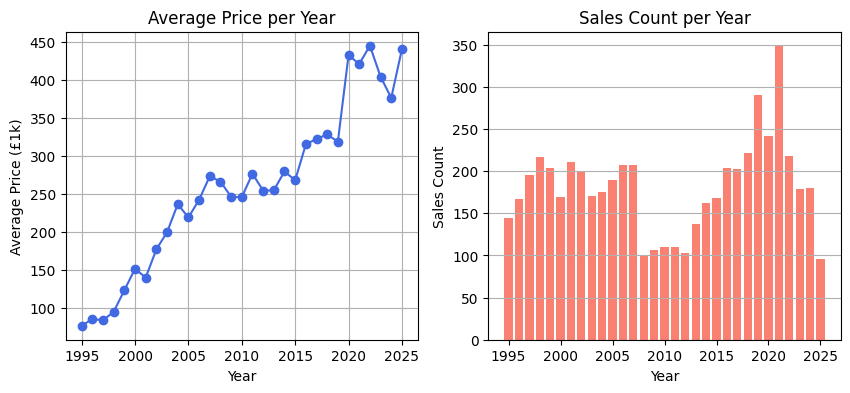

In [ ]:
import matplotlib.pyplot as plt
con = duckdb.connect("../data/main.db")

result_df = con.sql("""
    SELECT 
        year(deed_date) as year,
        AVG(price_paid) as avg_price,
        COUNT(*) as sales_count
    FROM transactions
    GROUP BY year
    ORDER BY year
""").df()
display(result_df.sample(5))

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Plot average price per year
axs[0].plot(result_df["year"], result_df["avg_price"] / 1000, marker="o", color="royalblue")
axs[0].set_title("Average Price per Year")
axs[0].set_xlabel("Year")
axs[0].set_ylabel("Average Price (£1k)")
axs[0].grid(True)

# Plot sales count per year
axs[1].bar(result_df["year"], result_df["sales_count"], color="salmon")
axs[1].set_title("Sales Count per Year")
axs[1].set_xlabel("Year")
axs[1].set_ylabel("Sales Count")
axs[1].grid(axis="y")


In [46]:
con = duckdb.connect("../data/main.db")

result_df = con.sql("""
    SELECT 
        strftime(deed_date, '%Y-%m') AS year_month,
        AVG(price_paid) as avg_price,
        COUNT(*) as sales_count
    FROM transactions
    GROUP BY year_month
    ORDER BY year_month
""").df()

result_df["date"] = pd.to_datetime(result_df['year_month'] + '-01')
display(result_df.sample(5))

,year_month,avg_price,sales_count,date
128,2005-09,239063.793103,29,2005-09-01
11,1995-12,93187.375000,8,1995-12-01
287,2018-12,310068.250000,24,2018-12-01
70,2000-11,169849.000000,10,2000-11-01
251,2015-12,229950.000000,20,2015-12-01


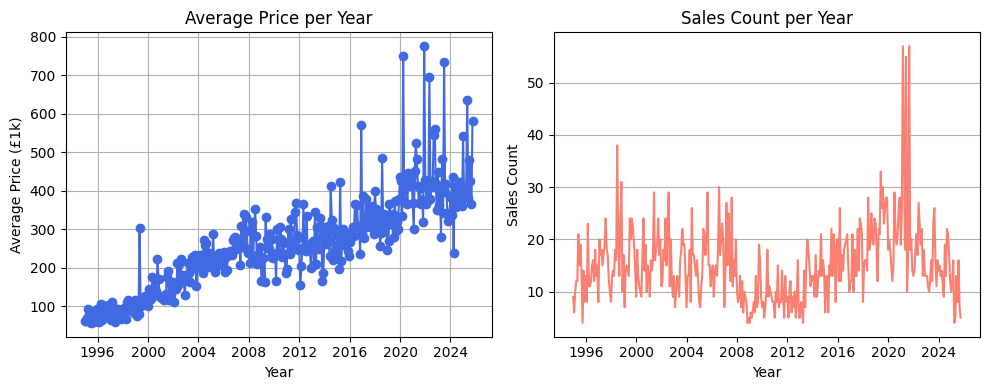

In [47]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Plot average price per year
axs[0].plot(result_df["date"], result_df["avg_price"] / 1000, marker="o", color="royalblue")
axs[0].set_title("Average Price per Year")
axs[0].set_xlabel("Year")
axs[0].set_ylabel("Average Price (£1k)")
axs[0].grid(True)

# Plot sales count per year
axs[1].plot(result_df["date"], result_df["sales_count"], color="salmon")
axs[1].set_title("Sales Count per Year")
axs[1].set_xlabel("Year")
axs[1].set_ylabel("Sales Count")
axs[1].grid(axis="y")

plt.tight_layout()
plt.show()